In [133]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 4 - Fall 2019
## Due 9 AM, Monday 11 Nov, 2019

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


**1.** Let's compare our dimensionalized, Barnes-style weight function to Gaussian function in `scipy.signal.windows.gaussian`. We understand its nondimensional frequency response quite well using theory from Koch, Trapp and Doswell, etc. However, the functions in `scipy.signal.windows.gaussian` control the cutoff in terms of the standard deviation. Since the functions are mathmatically equivalent, we should be able to reconcile them.

**a.** Using a data spacing of $\Delta=10$ m, what is the nyquist length scale $L_n$, and the spatial sampling frequency $f_s$ and nyquist $f_n$?


In [135]:
# defining initial variables

delta = 10 #m
Ln = 2*(delta)
fs = 1/(delta)
fn = 1/(2*delta)

# Here is thhe Ln, fs, and fn
print(Ln, fs, fn, 1.0/Ln)

20 0.1 0.05 0.05


Let's assume we have $N=2047$ samples of data and sample at evenly spaced locations $x$ from $0$ to $(N-1)\Delta$.

To get a feel for what data looks like in the frequncy domain transform, let's look at a step function, a linear ramp, and a sine wave. The function provided below calcualtes the Fourier transform and plots its amplitude and phase response. You'll use this plot for the rest of the assignment.

**b.** There is no waviness to the ramp. Why is there amplitude at so many frequencies? 

**c.** When you run the code to show the FFT of the sine wave, why is there amplitude at more than a single frequency?

0.0 20460.0
4.885197850512946e-05 4.885197850512946e-05
-0.04997557401074744 0.04997557401074744 0.05
-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


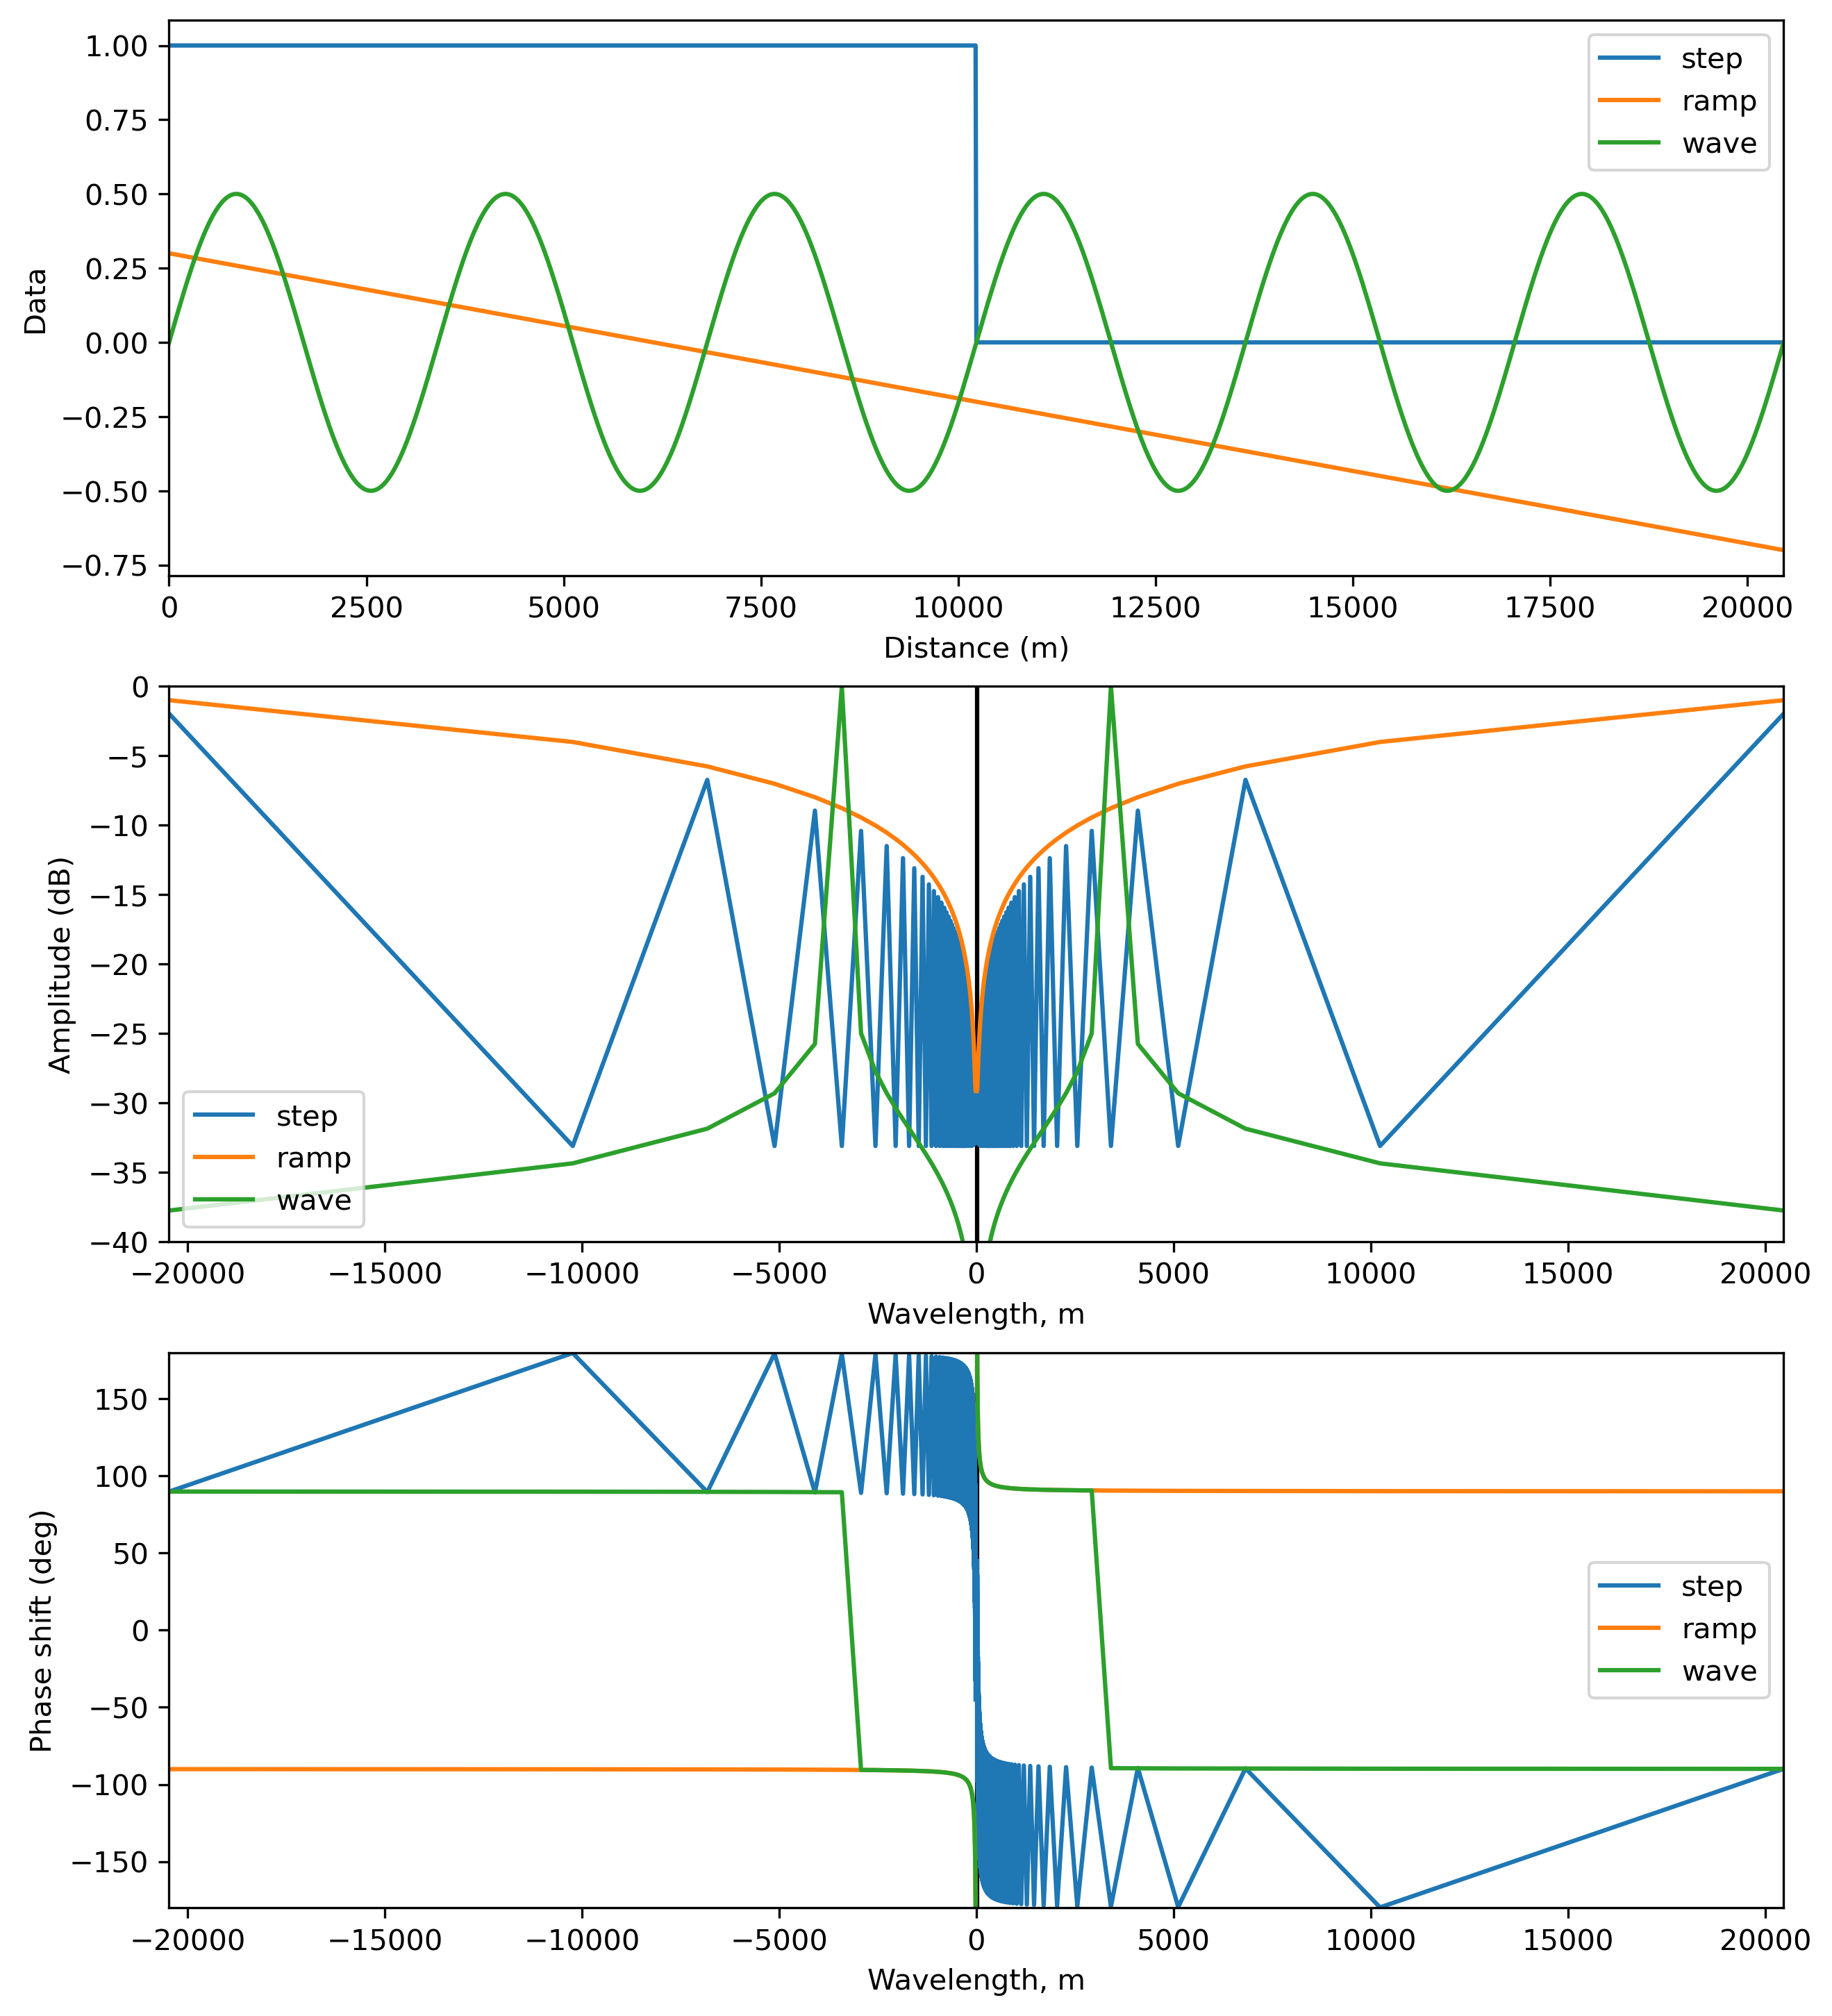

In [136]:
#Code given to us

N = 2047
x = np.arange(N, dtype='f8')*delta
print(x.min(), x.max())

freqs = np.fft.fftfreq(N, delta)
df = freqs[1]-freqs[0]
# frequency interval is the same as that calculated theoretically from fs/N
print(df, fs/N)
# and so is the Nyquist
print(freqs.min(), freqs.max(), fn)

fftshift = np.fft.fftshift

def dB(a,base=1.0):
    return 10.0*np.log10(a/base)

def response_plot(signals, x, axs, freq, labels=None, wavelength=False, dB_amp=True):
    """ Signals is a tuple or list (or iterable) of signals.
    """
    if labels is None:
        labels = range(len(signals))
    ax_t, ax_f, ax_p = axs
    
    if wavelength:
        freqs = 1.0/freq
        freq_label = 'Wavelength, m' 
        fmin, fmax = np.nanmin(freqs), -np.nanmin(freqs)
        for ax in [ax_f, ax_p]: ax.axvline(Ln, color='k')
    else:
        freqs = freq
        freq_label = 'Spatial Frequency, m^-1' 
        fmin, fmax = np.nanmin(freqs), np.nanmax(freqs)
    print(fmin, fmax)
    
    for signal, label in zip(signals, labels):
        fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
        amplitude = np.abs(fftshift(fft_s))
        amplitude /= amplitude.max()
        phase = np.angle(fftshift(fft_s))
        
#         print(amplitude.max(), amplitude.min(), np.all(~np.isfinite(amplitude)))
#         print(phase.max(), phase.min())

        ax_t.plot(x, signal, label=label)
        ax_t.set_ylabel('Data')
        ax_t.set_xlabel('Distance (m)')
        ax_t.set_xlim(x.min(), x.max())
        john = ax_t.legend()

        if dB_amp:
            ax_f.plot(fftshift(freqs), dB(amplitude), label=label)
            ax_f.set_ylim(-40,0)
            ax_f.set_ylabel('Amplitude (dB)')
        else:
            ax_f.plot(fftshift(freqs), amplitude, label=label)
            ax_f.set_ylim(0,1)
            ax_f.set_ylabel('Amplitude (linear)')
        ax_f.set_xlim(fmin, fmax)
        ax_f.set_xlabel(freq_label)
        john = ax_f.legend()

        ax_p.plot(fftshift(freqs), np.degrees(phase), label=label)
        ax_p.set_ylim(-180,180)
        ax_p.set_xlim(fmin, fmax)
        ax_p.set_ylabel('Phase shift (deg)')
        ax_p.set_xlabel(freq_label)
        john = ax_p.legend()
        

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

step = np.zeros_like(x)
step[:int(N/2)] = 1.0

ramp = -x/x.max() + 0.3

wave = np.sin(x*12*np.pi/x.max())/2

signals = [step, ramp, wave]
labels = ['step', 'ramp', 'wave']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

2b. In order to have a stright line in Fourier form, you would need an infinitie number of terms at an infinite number of frquencies for it to be straight. So there is no waviness becuase it has infininte terms at infinite frequencies. 

2c. If you look at the sin wave, you will notice that it oscillates between .5 and -.5. It's amplitude has two peaks and more than one amplitude at a single amplitude. This is becuase of the sin wave oscillation between .5 and 5. It is basically symmetric of nyquist frequency.

**2.** 

**a.** Implment the Barnes distance-dependent weighting function for $\kappa^* = 0.1$ and $0.5$. Center the weight function in the middle of the time series.

**b.** Simulate an artificial cutoff radius by setting any weights with value less than 0.1 to zero. This will give you four weight functions, two for each $\kappa^*$.

**c.** Use the `response_plot` function provided above to plot the four weight functions and their frequency domain response. Plot in wavelength mode, and zoom in to wavelengths between 0 and 200 (you don't need to show the negative wavelengths).

[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(-30.0, 10.0)

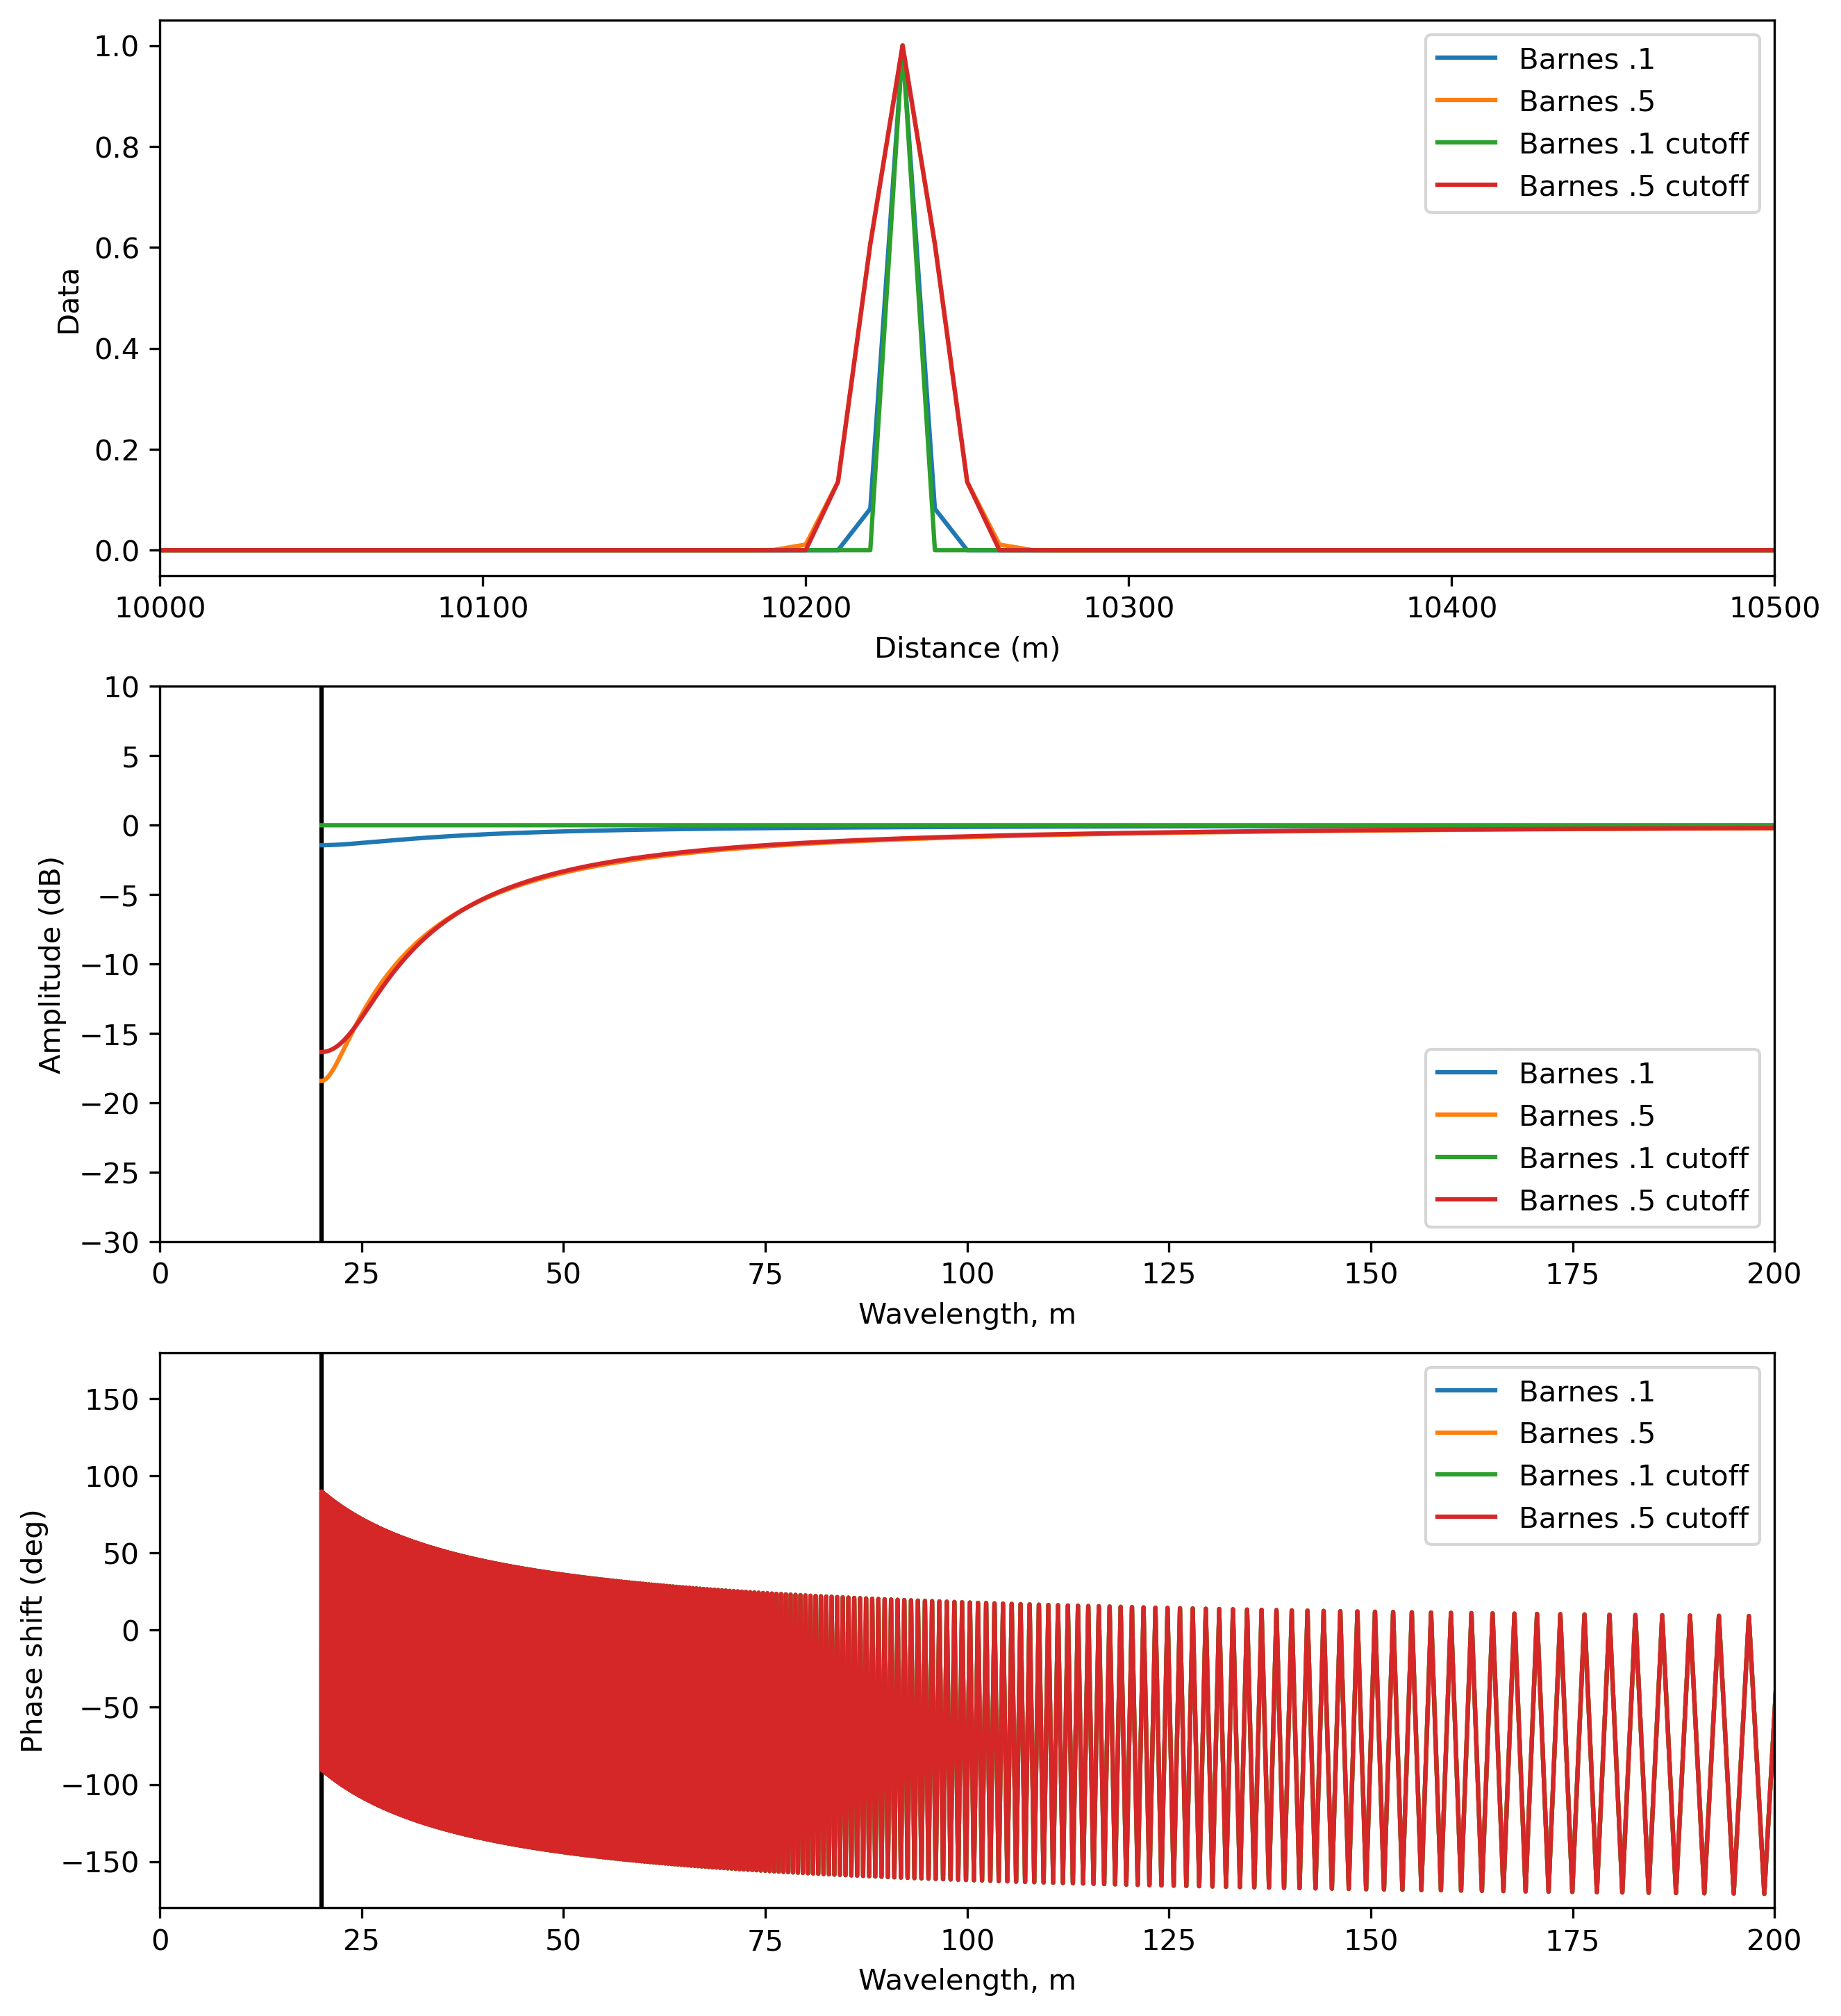

In [137]:
def barnes(r, k):
    
    # centering
    r_centered = r - np.max(r/2)
    # the weight function equation
    weight_f = np.exp(-(r_centered**2)/(4*(delta**2)*k))
    # cutoff radius less than .1
    cutoff_radius = (weight_f > 0.1)*weight_f
    # returning 
    return weight_f, cutoff_radius

# calling barnes function for each k star
weight_f_1, cutoff_r_1 = barnes(x, .1)
weight_f_2, cutoff_r_2 = barnes(x, .5)
print(weight_f_1, cutoff_r_1)
print(weight_f_2, cutoff_r_2)

from scipy.signal.windows import gaussian

# plot configuations below
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals1 = [weight_f_1, weight_f_2, cutoff_r_1, cutoff_r_2]
labels1 = ['Barnes .1', 'Barnes .5', 'Barnes .1 cutoff', 'Barnes .5 cutoff']
response_plot(signals1[:], x, axes, freqs, labels=labels1[:], wavelength=True)
axes[0].set_xlim(10000,10500)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)
axes[1].set_ylim(-30,10)

**3.** Instead of weighting with the distance dependent weighting function you wrote, let's use the built-in Gaussian function: `from scipy.signal.windows import gaussian`. It is formulated in terms of the standard deviation. In lecture we derived the relationship $\sigma = \sqrt{2\kappa^*}$. 

Reproduce your plot above using the built-in Gaussian window (weight) function.

-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(-30.0, 10.0)

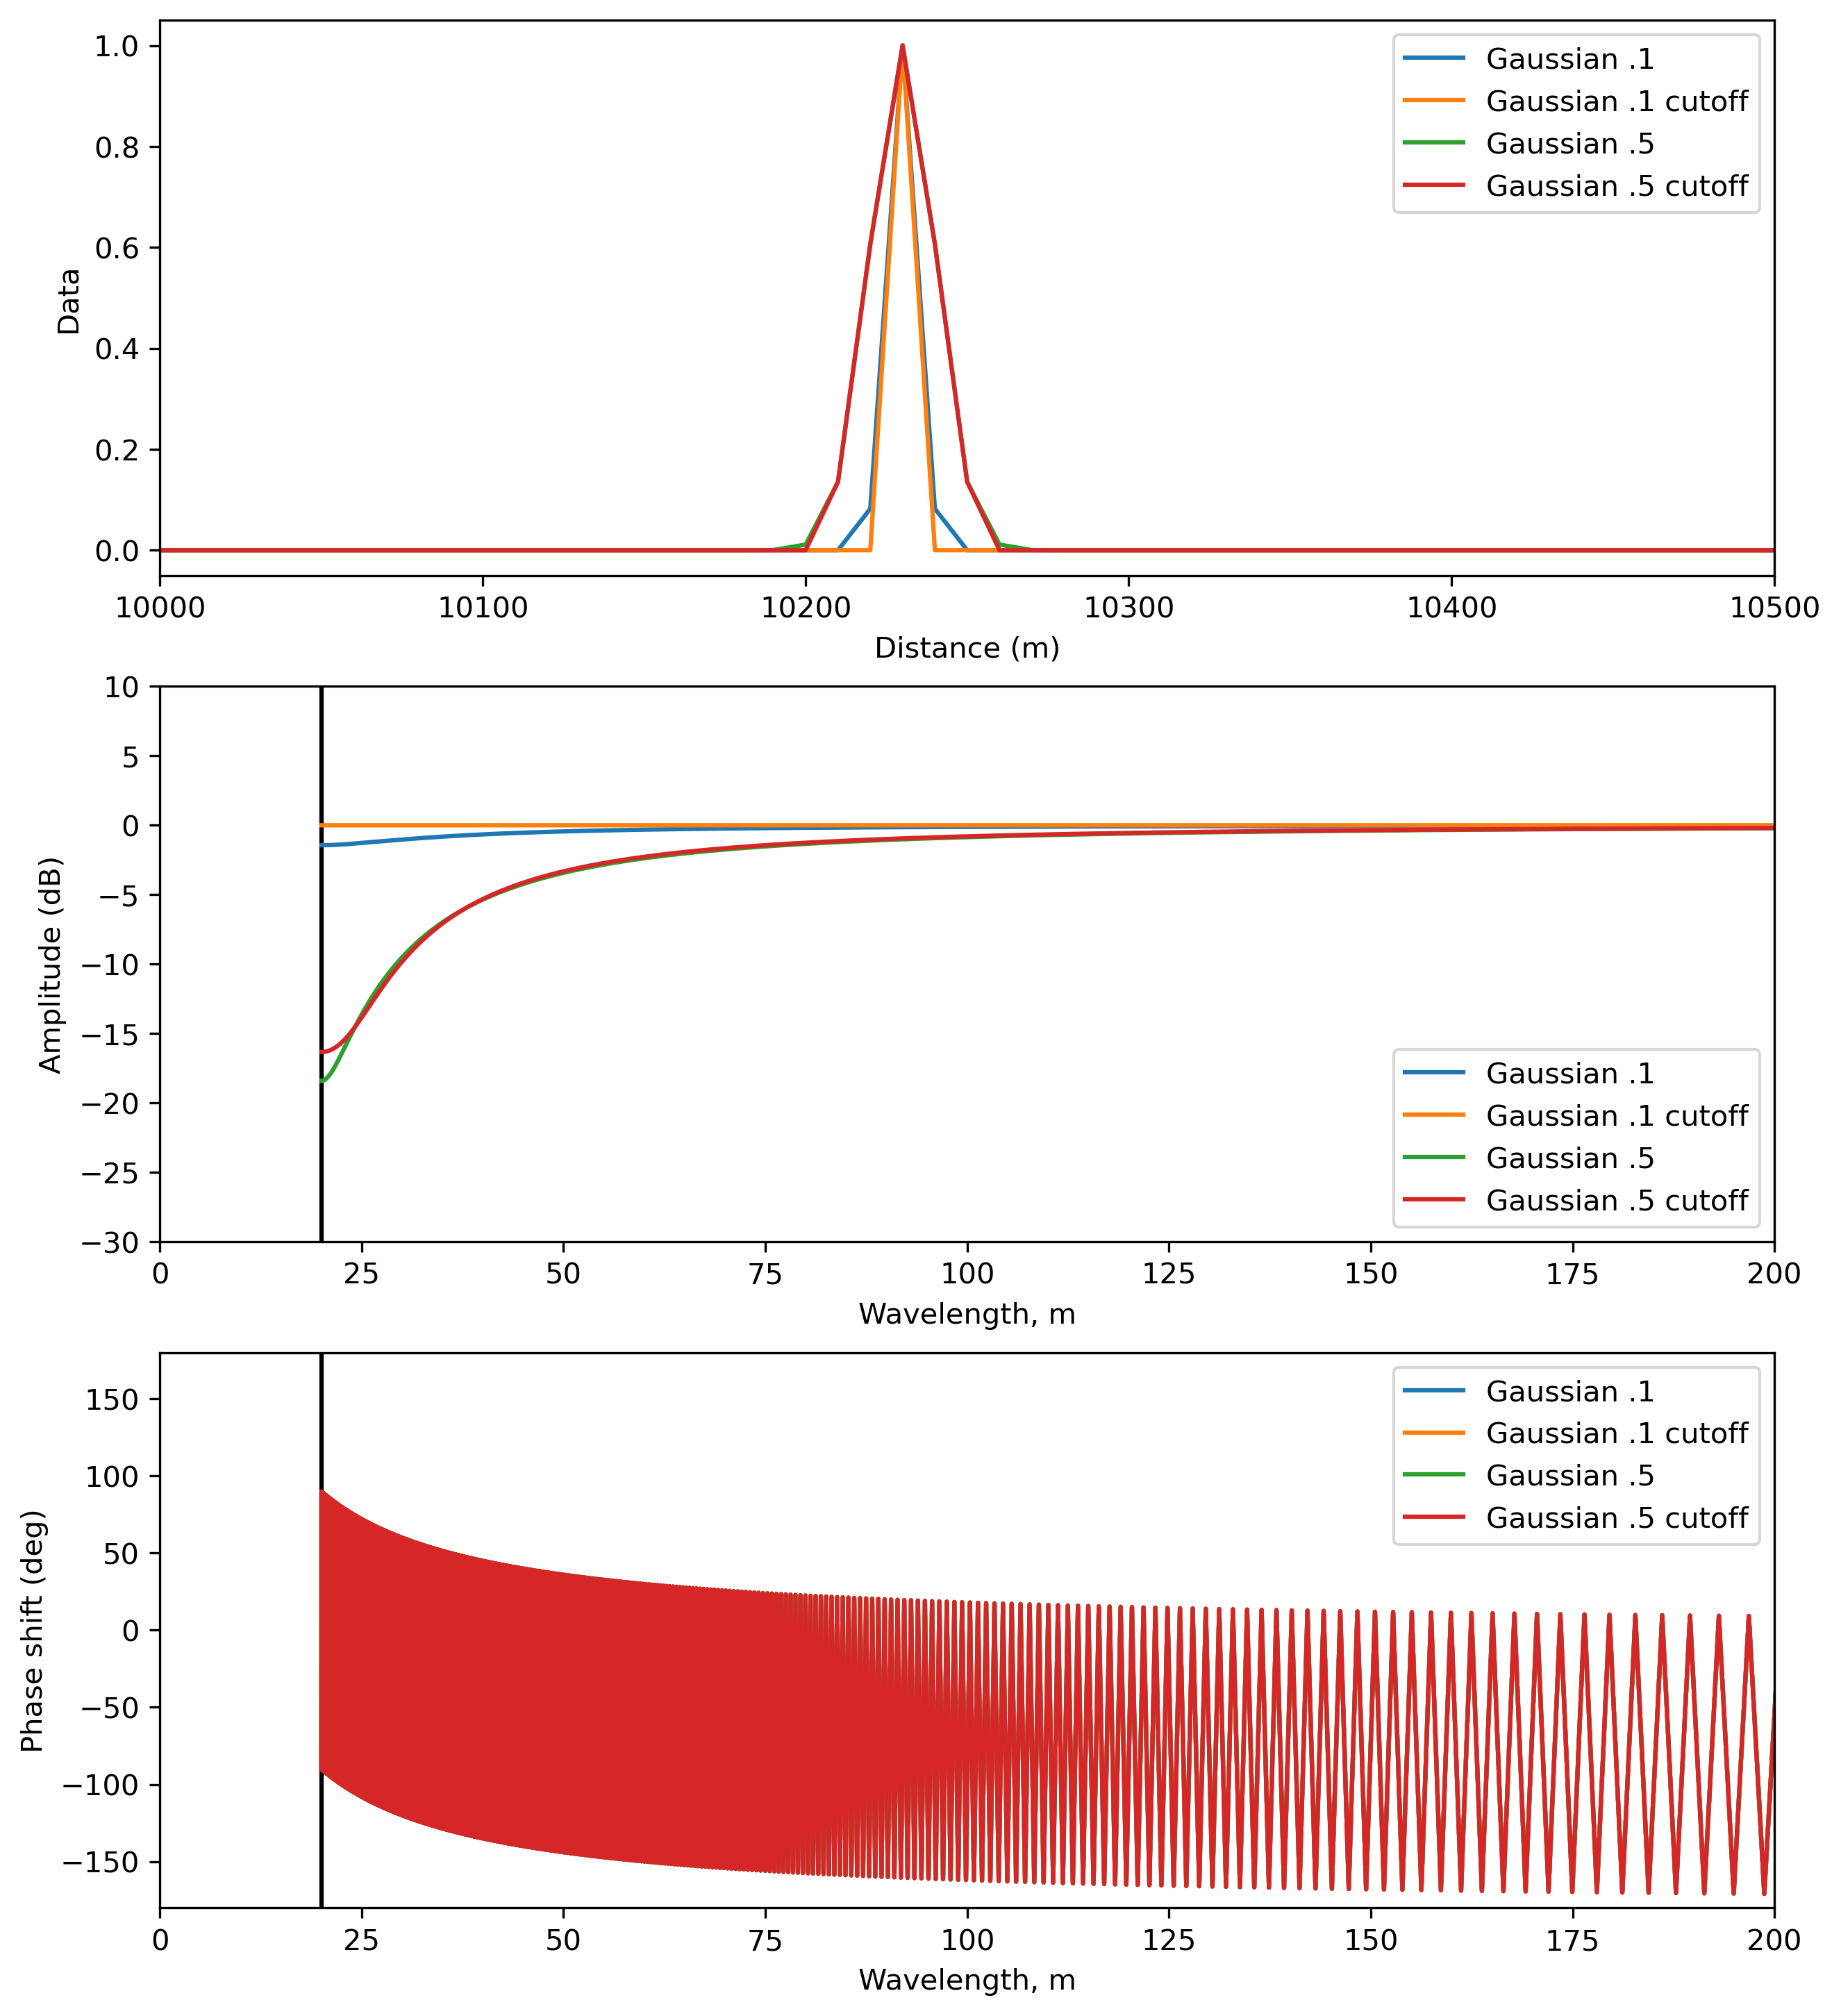

In [138]:
from scipy.signal.windows import gaussian

# sigma for .1 and .5 respectively
sigma1 = np.sqrt(2*.1)
sigma2 = np.sqrt(2*.5)
# using Gaussian function with sigmas for .1 and .5
w_sigma_1 = gaussian(N,sigma1)
w_sigma_2 = gaussian(N,sigma2)
# defining our cutoffs
cutoff_sigma1 = (w_sigma_1 > 0.1)*w_sigma_1
cutoff_sigma2 = (w_sigma_2 > 0.1)*w_sigma_2

# plotting configuations below
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals2 = [w_sigma_1, cutoff_sigma1, w_sigma_2, cutoff_sigma2]
labels2 = ['Gaussian .1', 'Gaussian .1 cutoff', 'Gaussian .5', 'Gaussian .5 cutoff']
response_plot(signals2[:], x, axes, freqs, labels=labels2[:], wavelength=True)
axes[0].set_xlim(10000,10500)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)
axes[1].set_ylim(-30,10)

**4.** Implement and plot the frequency response for 3- and 5-point rectangular weight (boxcar) functions.

-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(-30.0, 10.0)

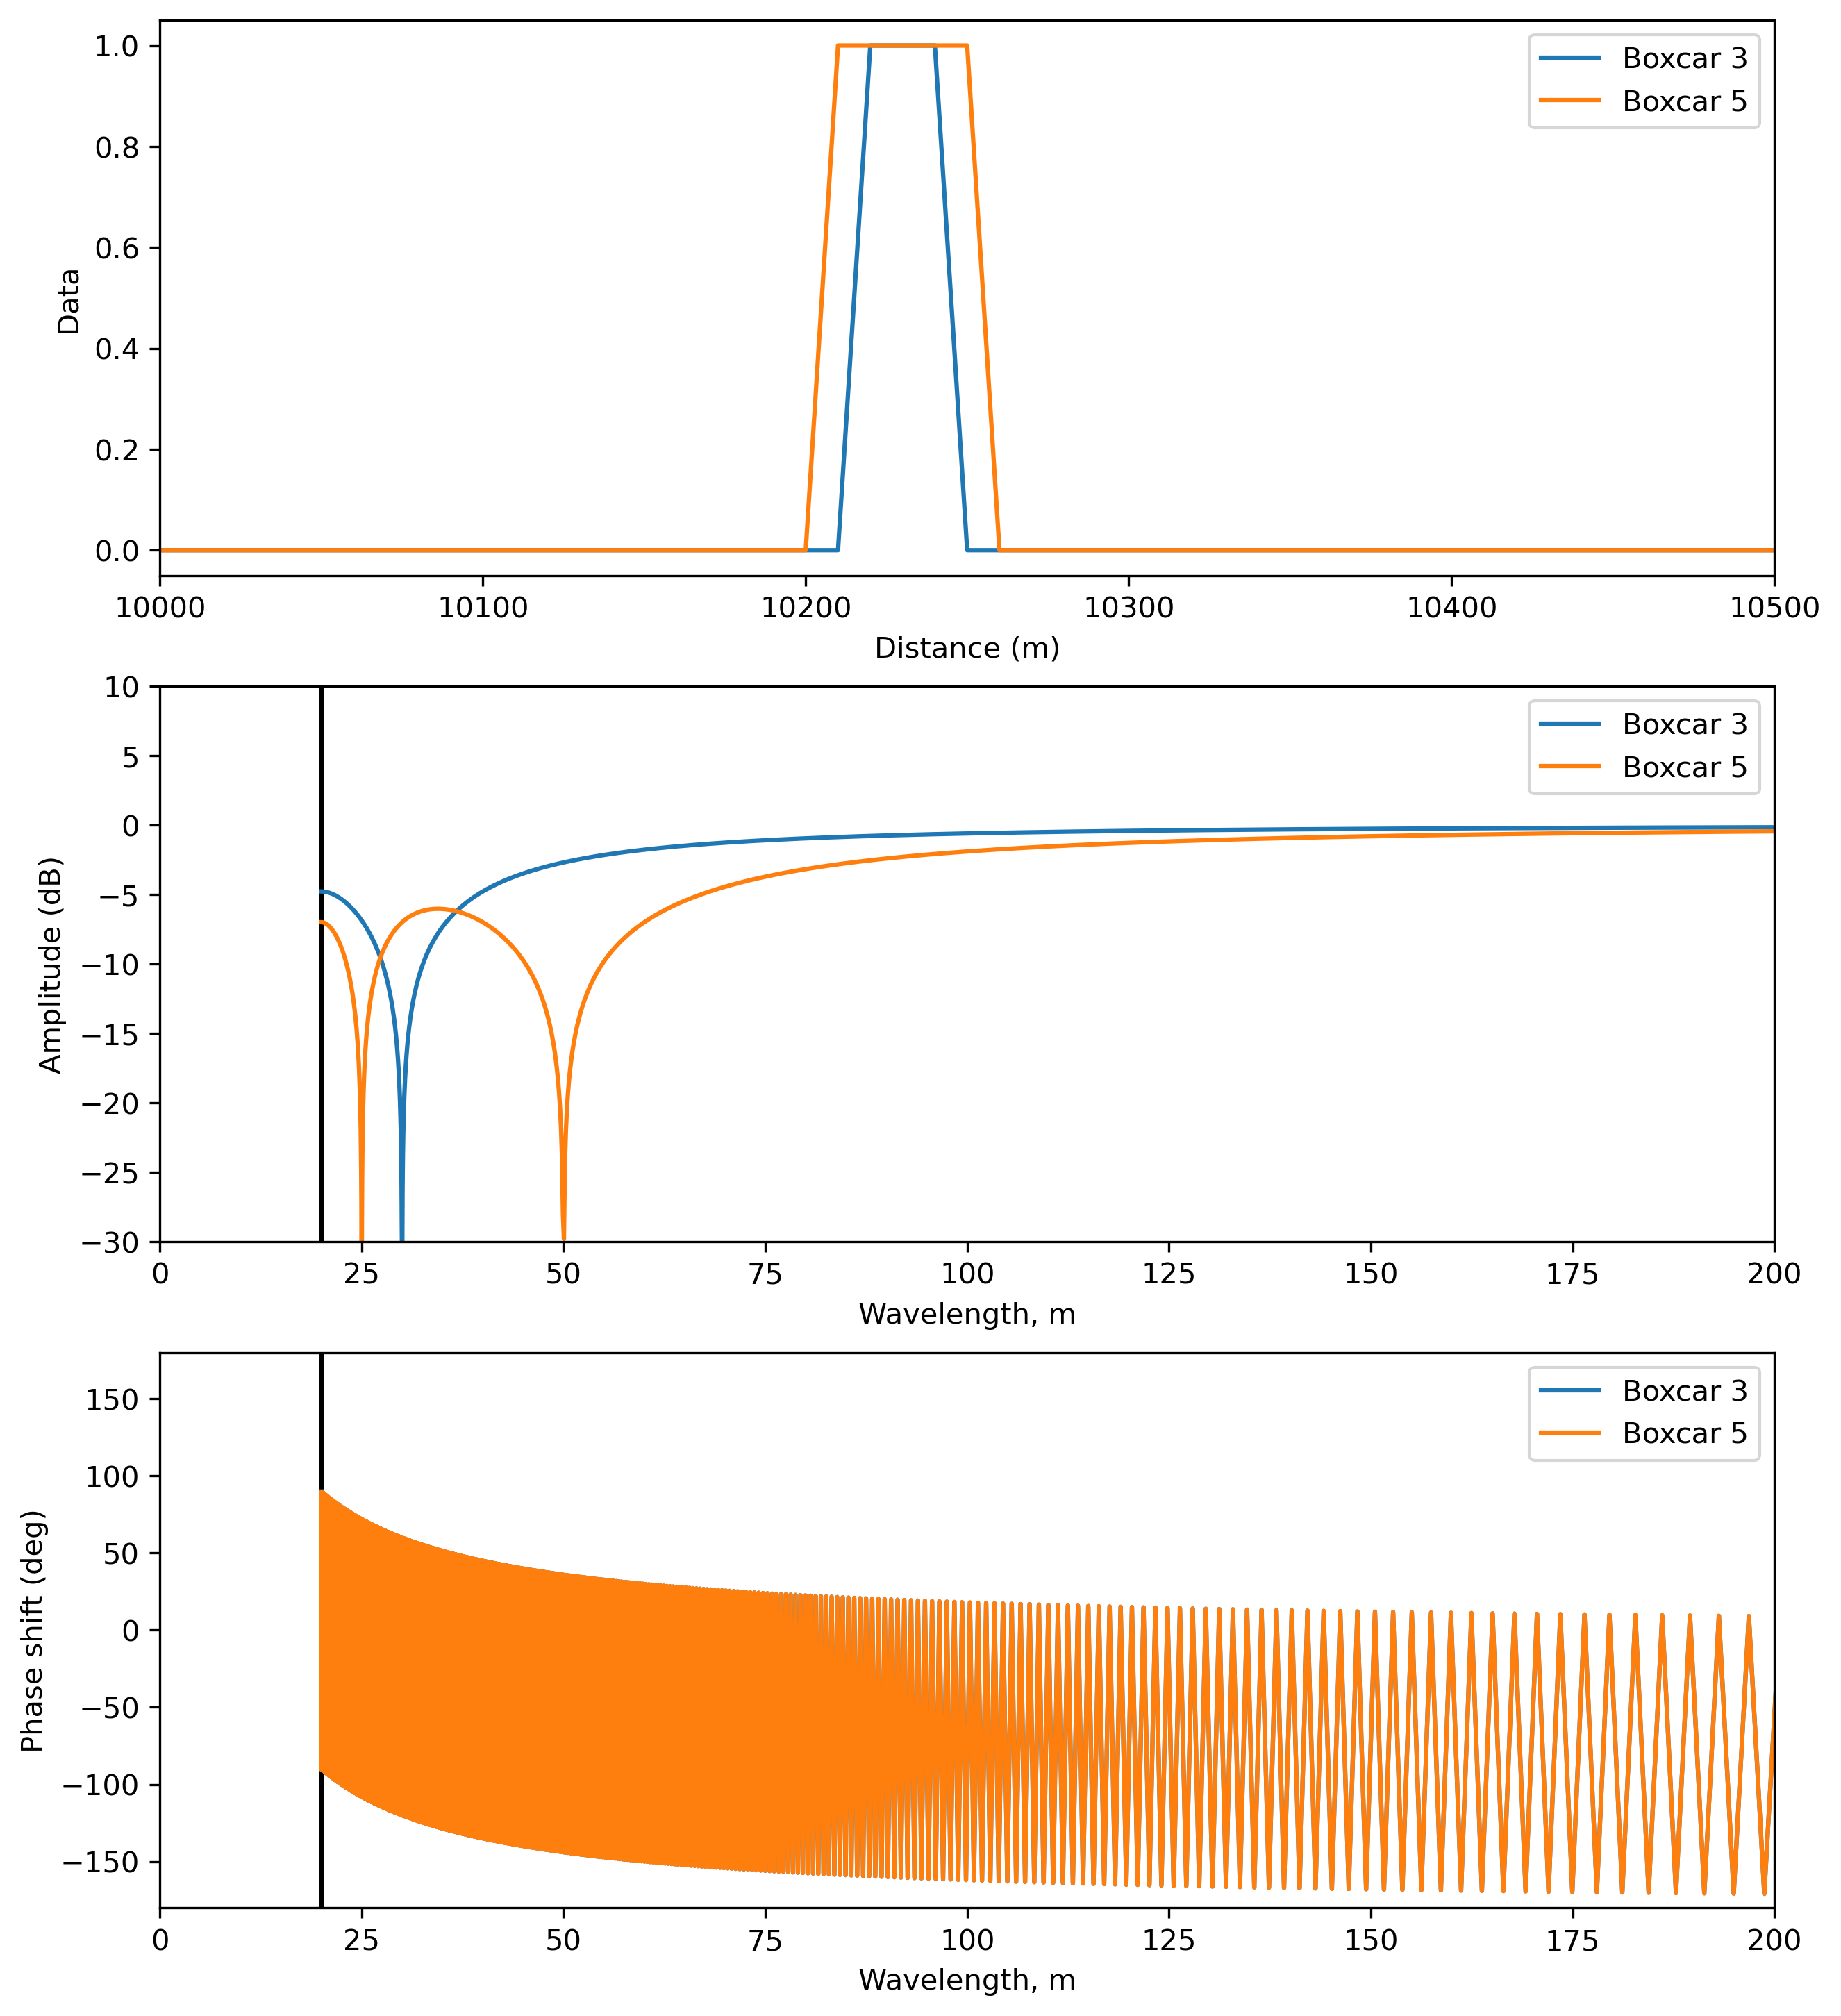

In [139]:
from scipy.signal.windows import boxcar

# boxcar function
b = boxcar(N)
b_center = int(len(b)/2)
box_3 = np.array(b)
# centering codes for 3
box_3[0:b_center-1]=0 
box_3[b_center+2:]=0 
# centering for 5
box_5 = np.array(b)
box_5[0:b_center-2]=0 
# centering
box_5[b_center+3:]=0 

# plot configurations
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals3 = [box_3, box_5]
labels3 = ['Boxcar 3', 'Boxcar 5']
response_plot(signals3[:], x, axes, freqs, labels=labels3[:], wavelength=True)
axes[0].set_xlim(10000,10500)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)
axes[1].set_ylim(-30,10)

**5.** Implement and plot a 5-point Parzen (Riesz) weight function. Also show the effect of an artifical cutoff by removing the weights below 0.1.

-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(-30.0, 10.0)

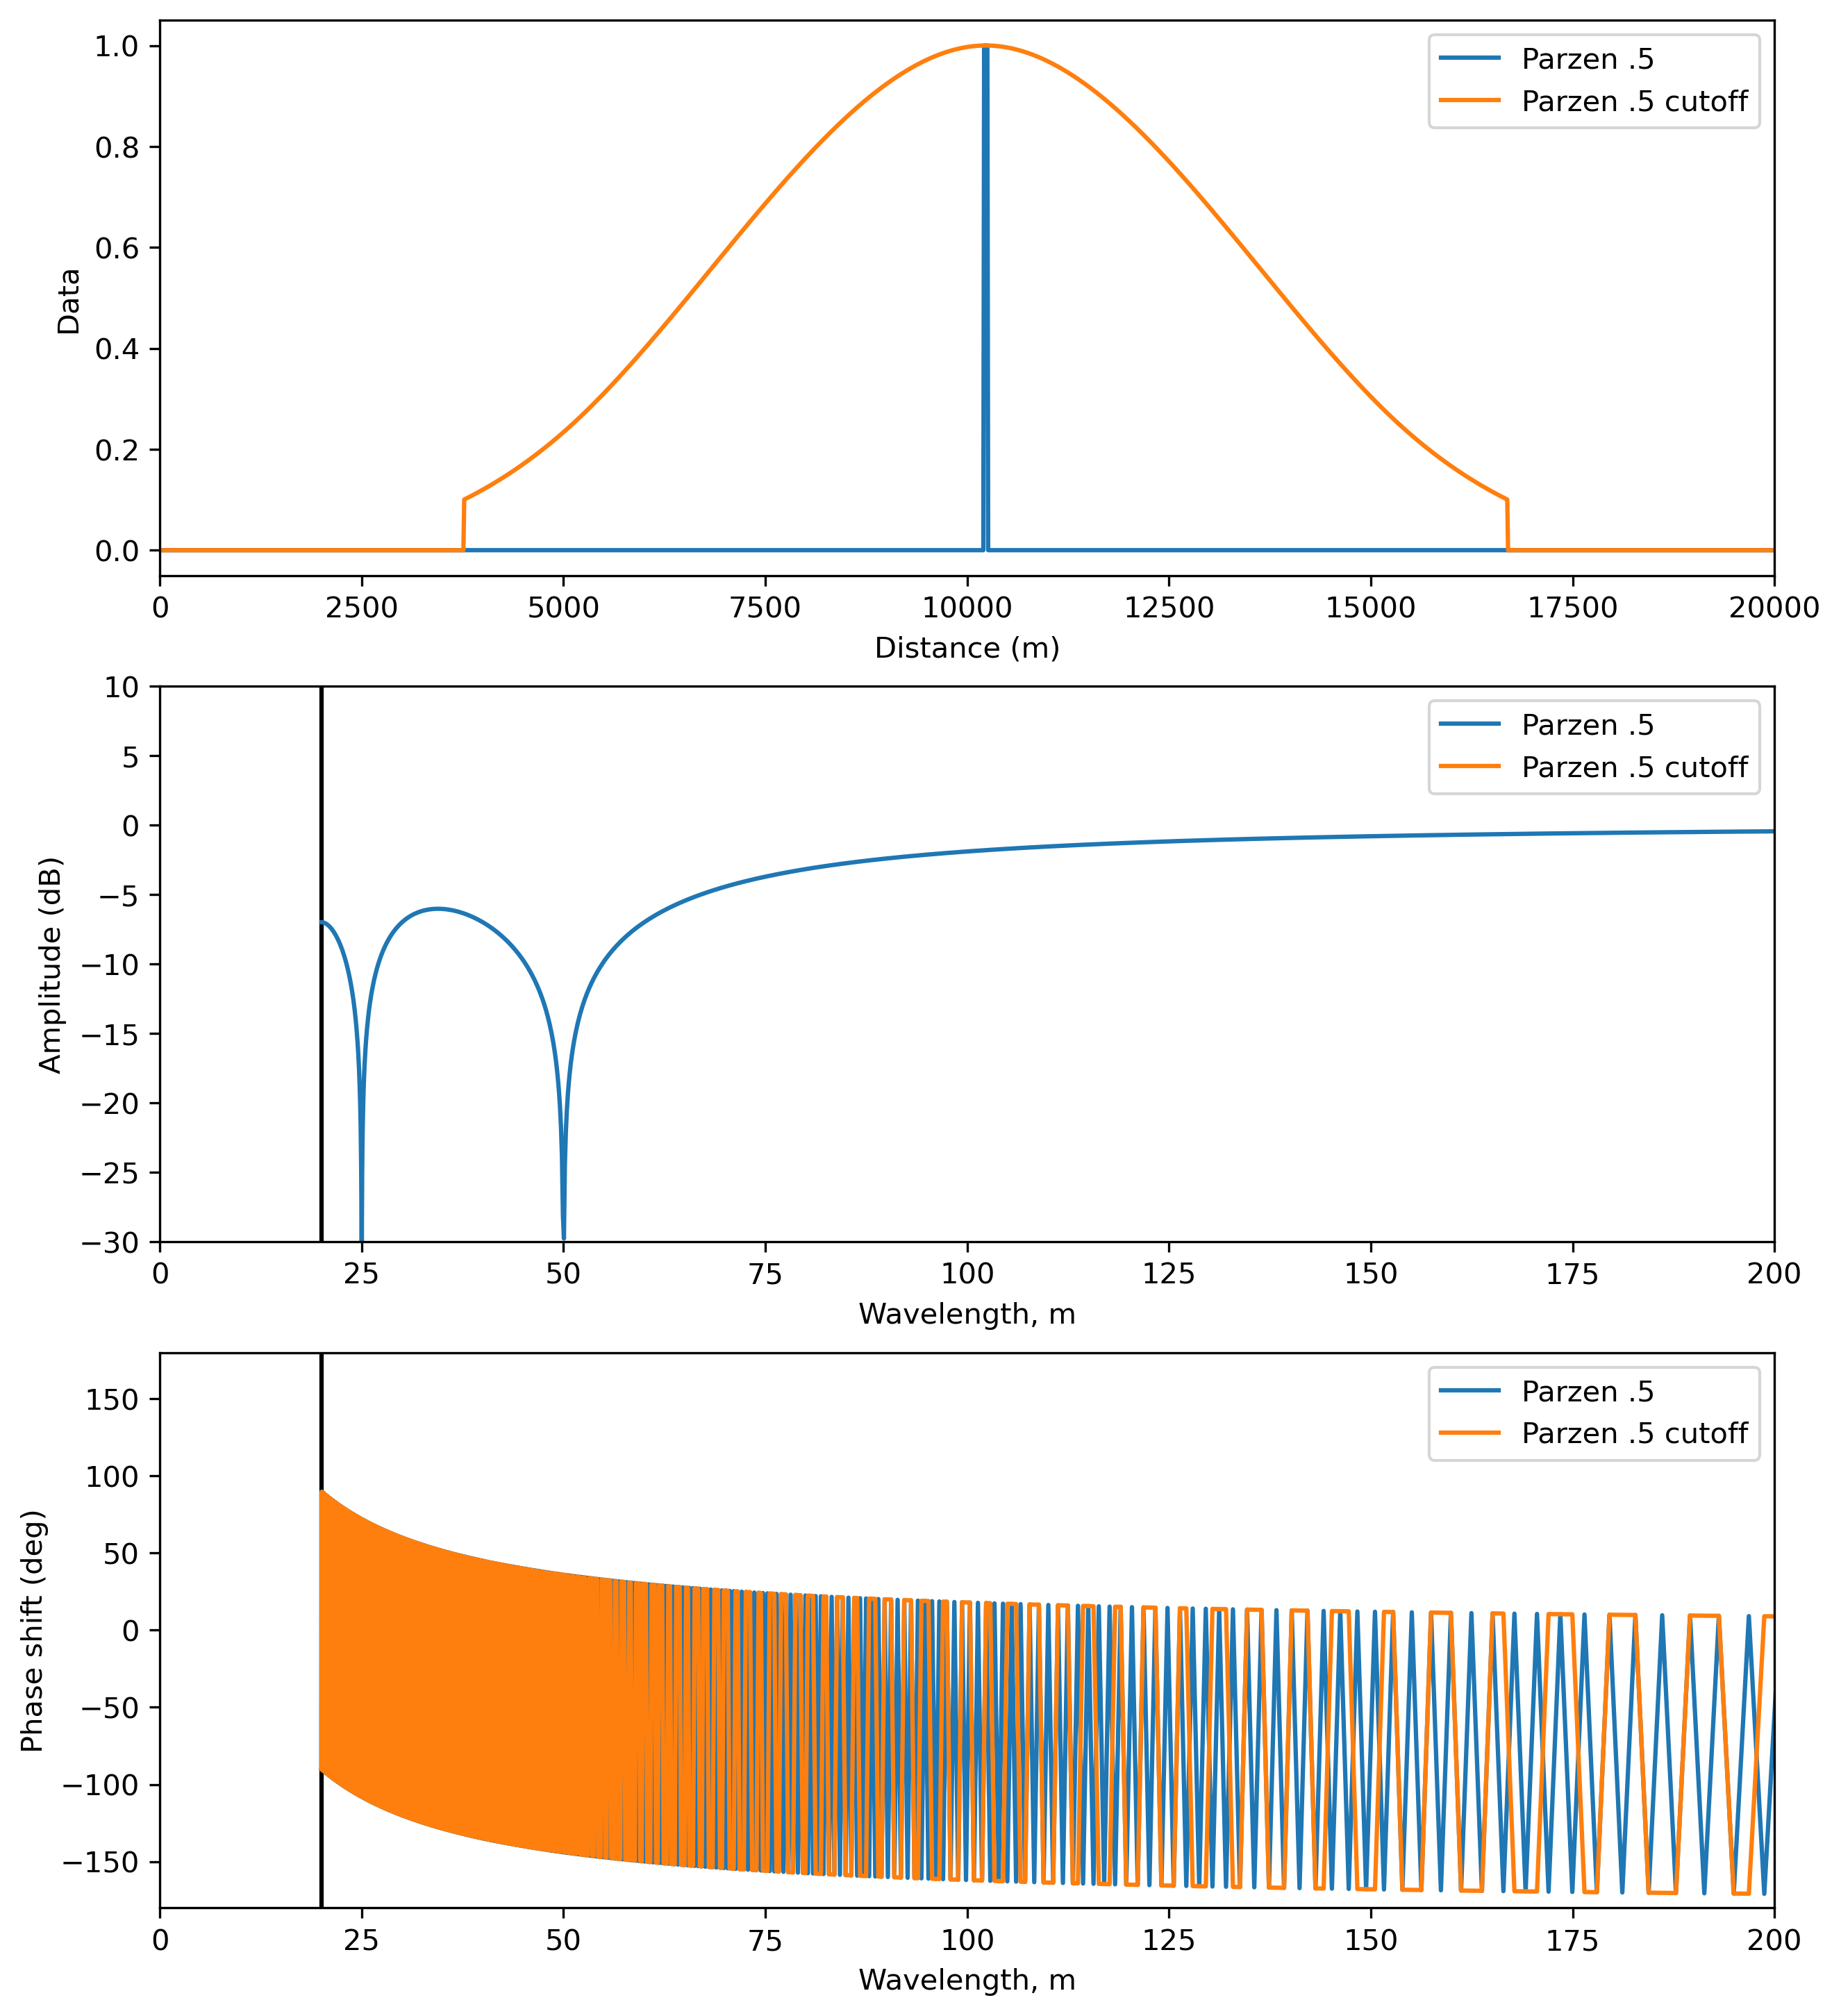

In [140]:
from scipy.signal.windows import parzen

# parzen function
p = parzen(N)
p_center = int(len(p)/2)
p5 = np.array(p)
# centering for 5 point
p5[0:p_center-2]=0
p5[p_center+3:]=0
# cutoff
p_cutoff = (p > 0.1)*p

# plotting 
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals4 = [p5, p_cutoff]
labels4 = ['Parzen .5', 'Parzen .5 cutoff']
response_plot(signals4[:], x, axes, freqs, labels=labels4[:], wavelength=True)
axes[0].set_xlim(0,20000)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)
axes[1].set_ylim(-30,10)

**6.** Implement and plot a 5-point Dolph-Chebyshev weight function with a lowest sidelobe level of 60 dB. Also show the effect of an artifical cutoff by removing the weights below 0.1.

-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

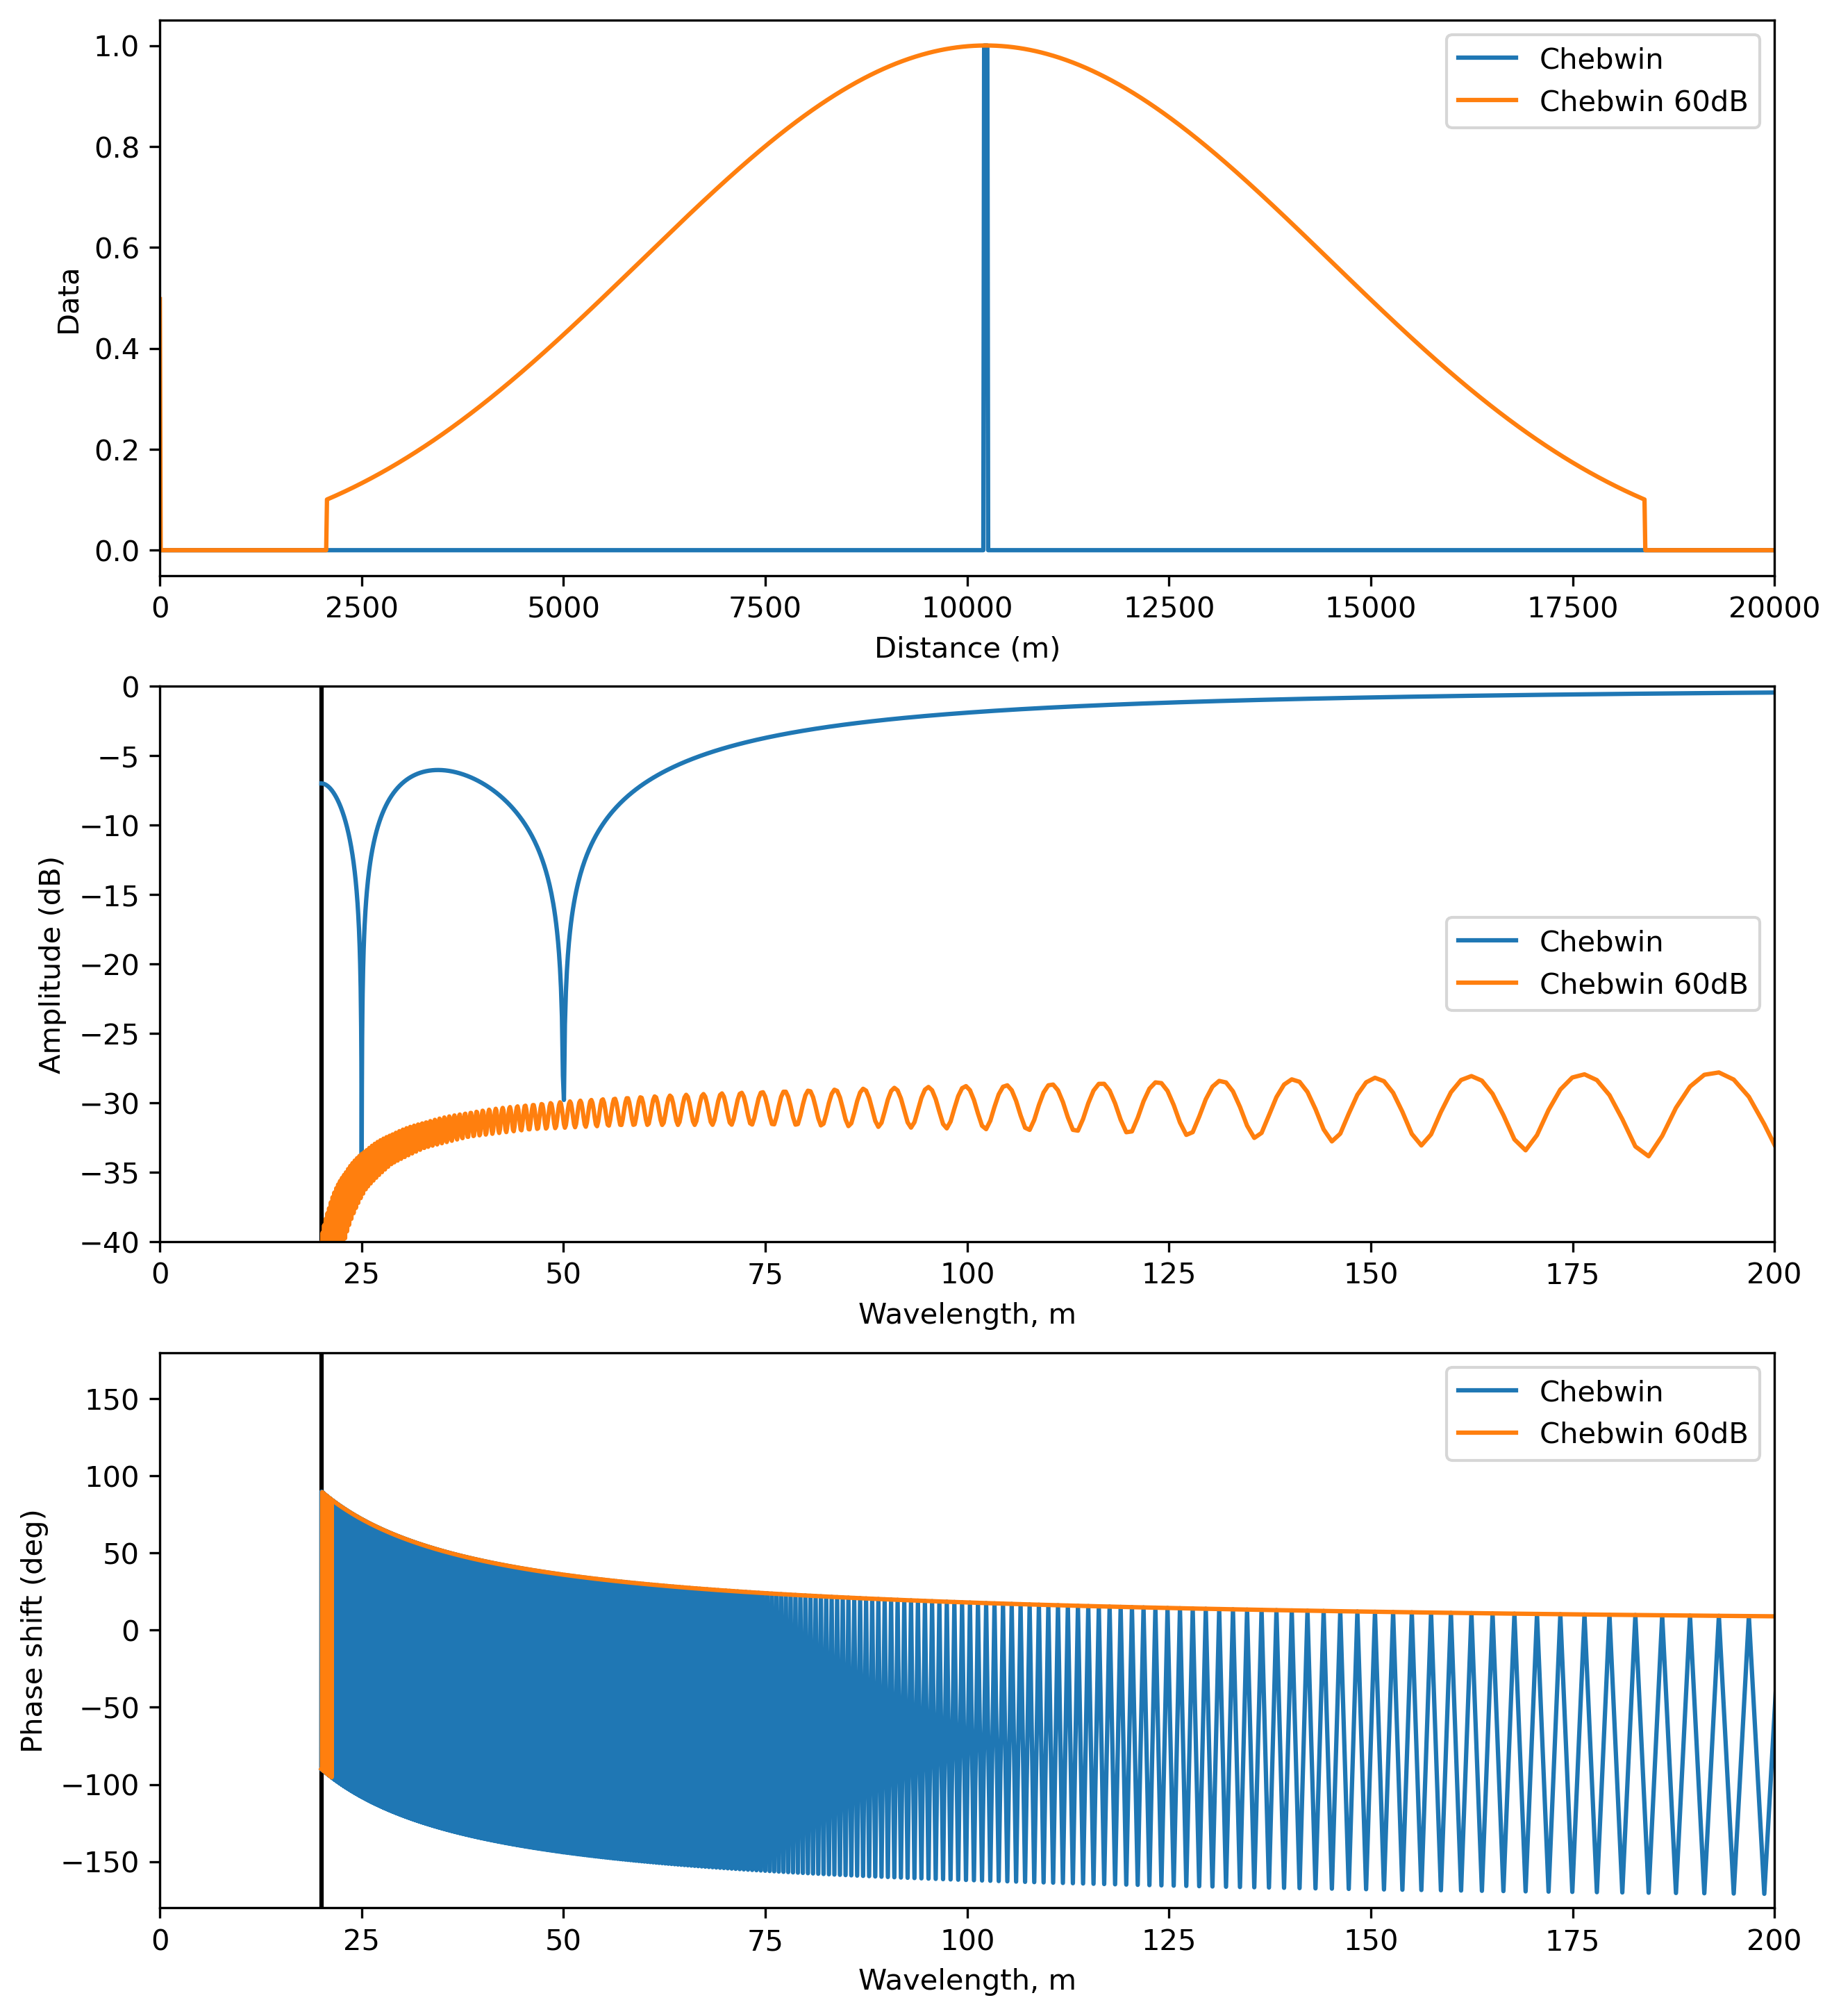

In [141]:
from scipy.signal.windows import chebwin

# Chebwin function
c = chebwin(N, 60)
c_center = int(len(c)/2)
c5 = np.array(c)
# centering
c5[0:p_center-2]=0
c5[p_center+3:]=0
# defining cutoff
c_cutoff = (c > 0.1)*c

# plotting 
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals5 = [c5, c_cutoff]
labels5 = ['Chebwin', 'Chebwin 60dB']
response_plot(signals5[:], x, axes, freqs, labels=labels5[:], wavelength=True)
axes[0].set_xlim(0,20000)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

**7.** Implement and plot a 7-point Blackman and a 7-point Blackman-Harris weight function. There is no need to show the effect of an artificial cutoff here.

-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(-40.0, 10.0)

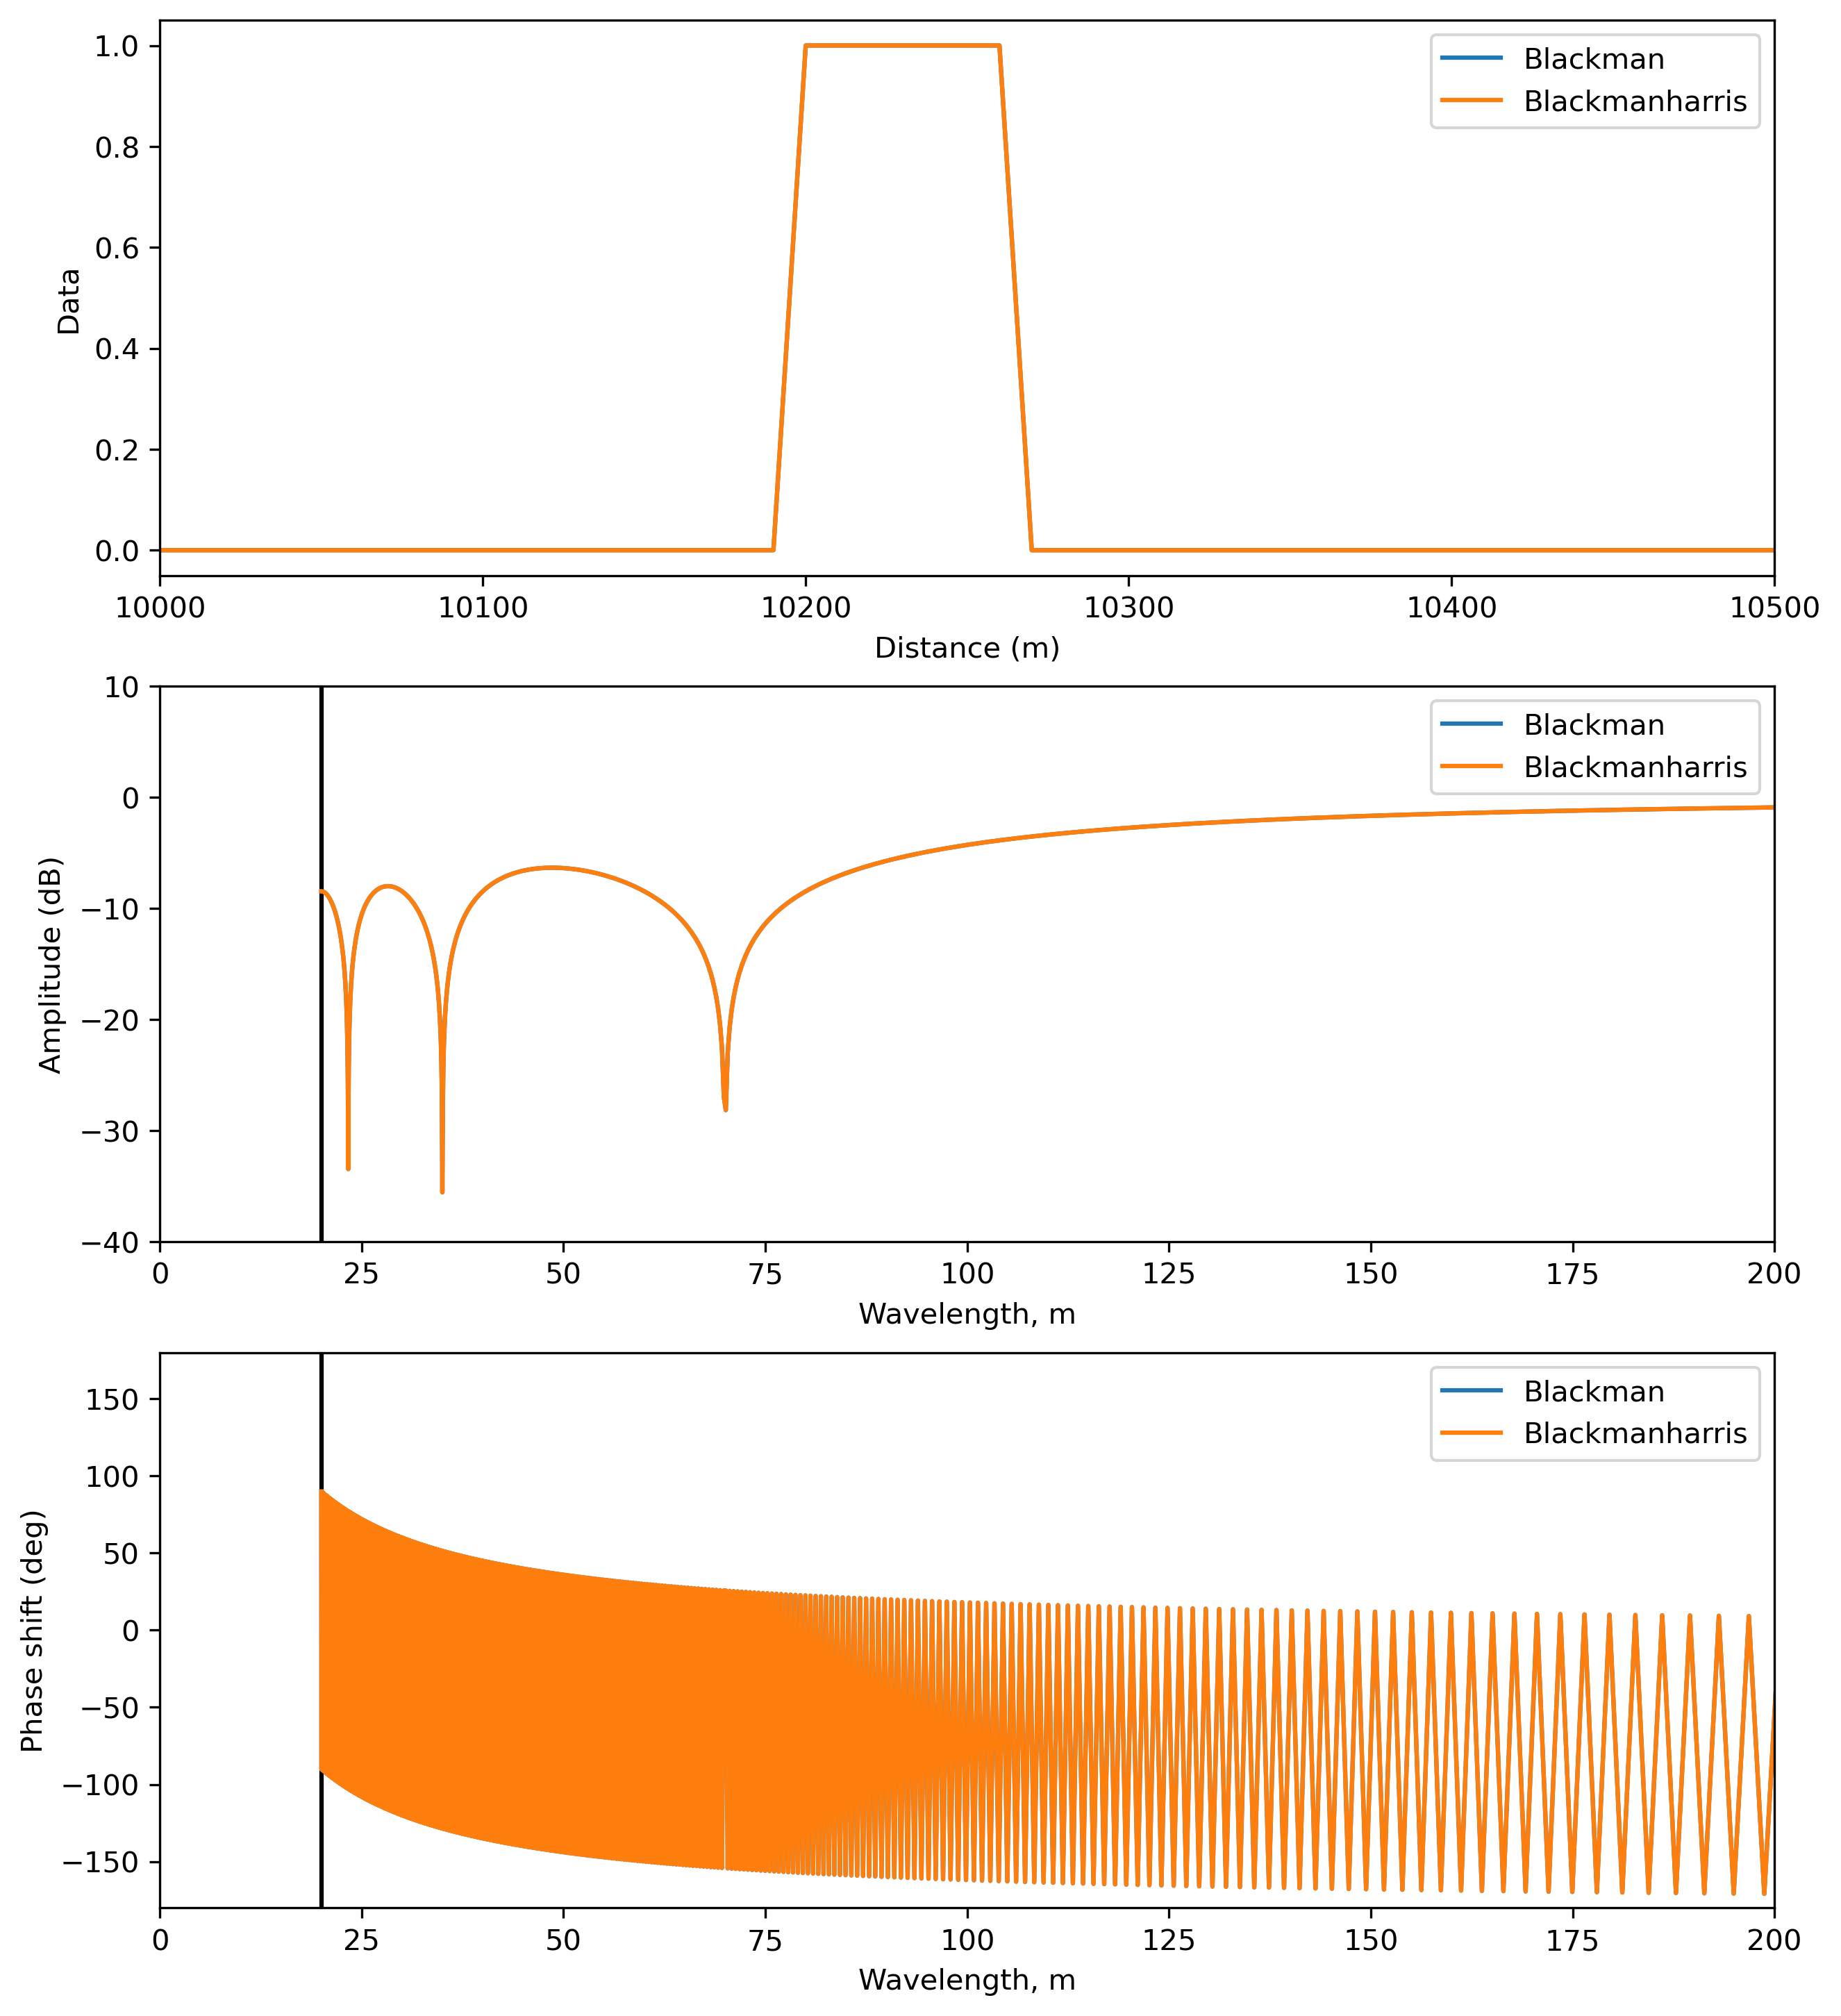

In [142]:
from scipy.signal.windows import blackmanharris, blackman

# blackman function
bl = blackman(N)
bl_center = int(len(bl)/2)
bl7 = np.array(bl)
# centering
bl7[0:bl_center-3]=0
bl7[bl_center+4:]=0

# blackmanharris function
blh = blackmanharris(N)
blh_center = int(len(blh)/2)
blh7 = np.array(blh)
# centering
blh7[0:blh_center-3]=0
blh7[blh_center+4:]=0

# Plotting
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals8 = [bl7, blh7]
labels8 = ['Blackman', 'Blackmanharris']
response_plot(signals8[:], x, axes, freqs, labels=labels8[:], wavelength=True)
axes[0].set_xlim(10000,10500)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)
axes[1].set_ylim(-40,10)

**8.** 

**a.** Plot all weight functions together on the same graph, excluding those that show the effect of an artificial cutoff. Use  `dB_amp=False` to show the amplitude response in linear units.

**b.** Assume our critiera for a best analysis ranks our priorties as follows:
1. Smooth frequency response
2. Minimum amplitude at the Nyquist
3. Maximum amplitude at relatively small wavelengths just next to the Nyquist

Which weight functions are worst by these critera?

Which weight function do you regard as best, and why?

**c.** Compare the Nyquist-crossing amplitudes of the two Gaussian weight functions to the values in Koch et al. (1983), Fig. 1. How does each crossing point differ? What is the reason for the differences?

8b. 

Is this an opinion based question? I feel like it could be based on how you evaluate them.

best: Blackman/Blackmanharris This is becuase it's smooth, has a minimum amp very close to Nyquist, and it max amplitude is at relatively small wavelengths next to the Nyquist. I could also see the Gaussian .5 being a postential best.

worst: Boxcar because its min amptlitudes do not occure at the Nyquist or at least not as close to the Nyquist as others. Also the Gaussian .1 becuase although it is smooth, it doesn't meet the second 2 criteria as well. 

8c. 

Gaussian .1: nyquist crossing amplitude around .7
Gaussian .5: nyquist crossing amplitude around 0
Koch .1: nyquist crossing amplitude around .35
Kochh .5: nyquist crossing amplitude around around 0 still
The .5's are pretty similar, while the .1's have a greater difference
The reason for this difference could be that we used FFT and the paper used a Do equation which is I believe an algebraic simplified equation.

-20470.0 20470.0


<ipython-input-136-7e118829e079>:27: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

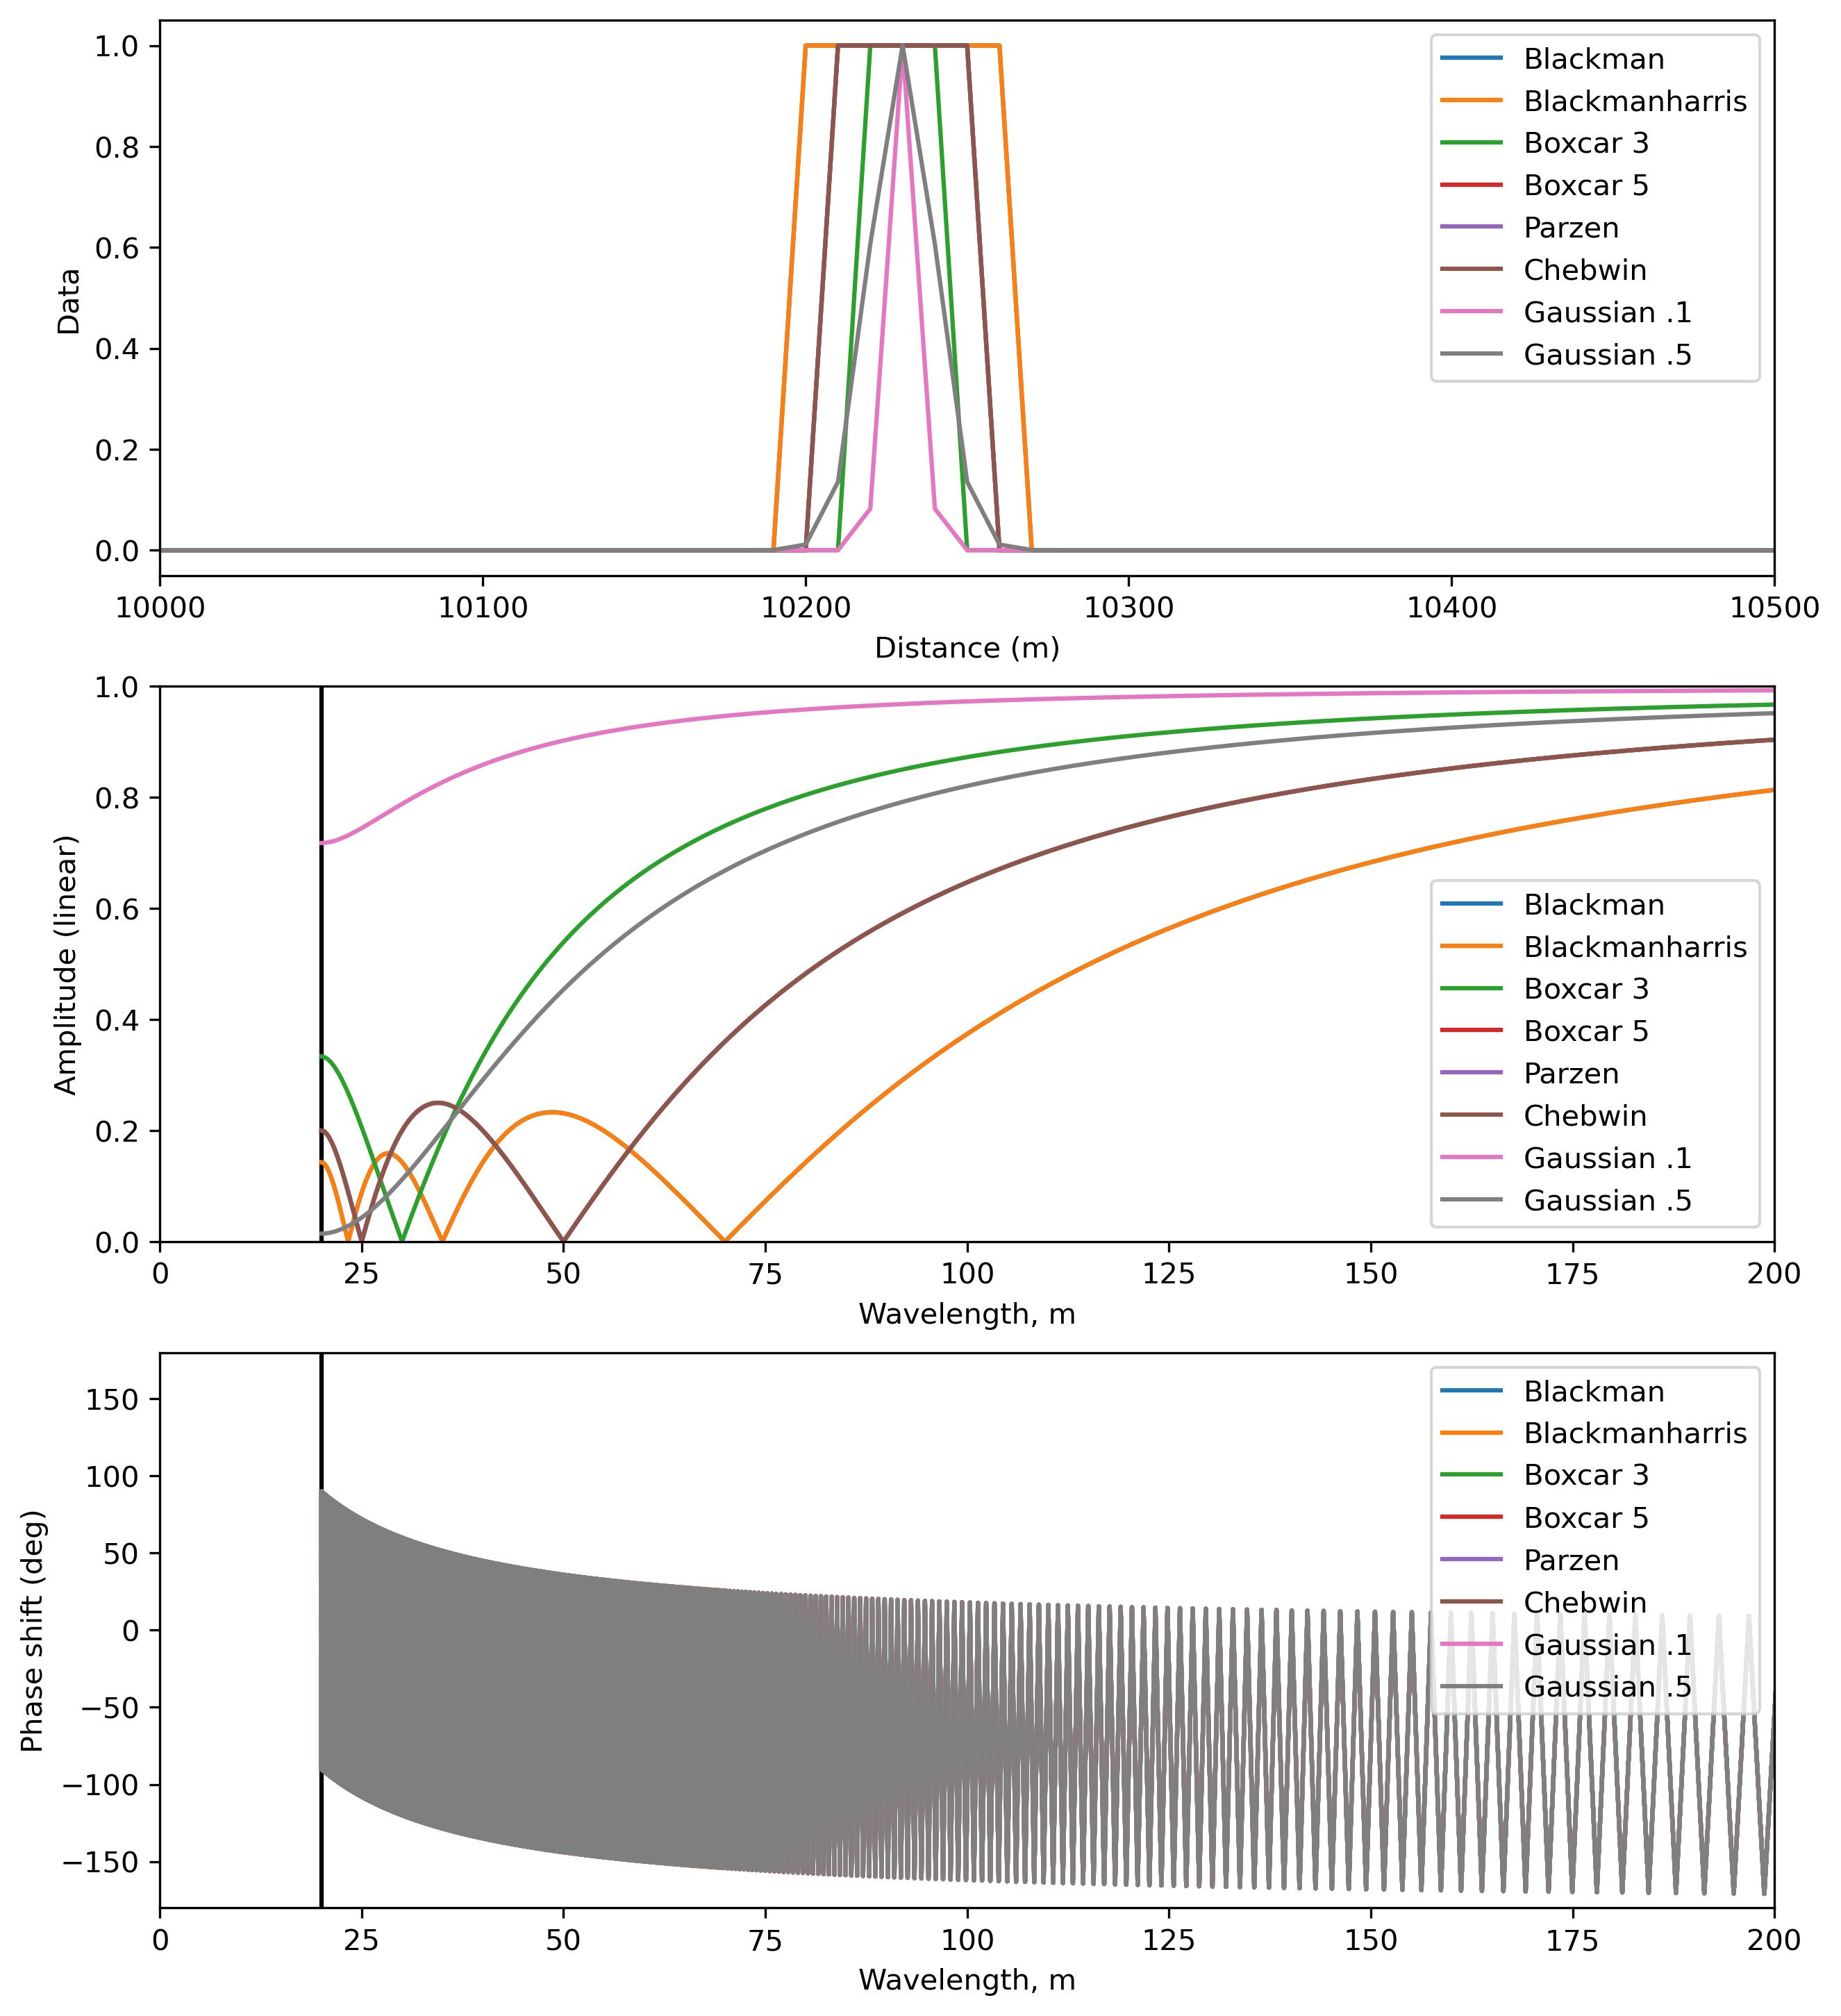

In [143]:
# combining them all together (besides the artifical cutoffs)
fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)
signals8 = [bl7, blh7, box_3, box_5, p5, c5, w_sigma_1, w_sigma_2]
labels8 = ['Blackman', 'Blackmanharris', 'Boxcar 3','Boxcar 5','Parzen','Chebwin','Gaussian .1','Gaussian .5']

# plotting
response_plot(signals8[:], x, axes, freqs, labels=labels8[:], wavelength=True, dB_amp=False)
axes[0].set_xlim(10000,10500)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)